## 0. Import

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Dense,Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from transformers import TFBertModel, TFAlbertModel, TFElectraModel, TFDistilBertModel, DistilBertModel
from transformers import ElectraTokenizer, BertTokenizerFast

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import datasets
from datasets import load_dataset, load_metric, ClassLabel, Sequence

In [2]:
strategy = tf.distribute.get_strategy()

## 1. Load Dataset

In [3]:
train = pd.read_csv("../dataset/train.csv", encoding='CP949')
test = pd.read_csv("../dataset/test.csv", encoding='CP949')
#train_multinli = pd.read_csv('../dataset/kornli/multinli.train.ko.tsv', delimiter='\t', error_bad_lines=False)
#train_snli = pd.read_csv('../dataset/kornli/snli_1.0_train.ko.tsv', delimiter='\t')
# datasets = load_dataset("klue", "nli")

In [4]:
train.head()

,index,premise,hypothesis,label
0,1,"삼성은 자작극을 벌인 2명에게 형사 고소 등의 법적 대응을 검토 중이라고 하였으나,...",자작극을 벌인 이는 3명이다.,contradiction
1,2,이를 위해 예측적 범죄예방 시스템을 구축하고 고도화한다.,예측적 범죄예방 시스템 구축하고 고도화하는 것은 목적이 있기 때문이다.,entailment
2,3,광주광역시가 재개발 정비사업 원주민들에 대한 종합대책을 마련하는 등 원주민 보호에 ...,원주민들은 종합대책에 만족했다.,neutral
3,4,"진정 소비자와 직원들에게 사랑 받는 기업으로 오래 지속되고 싶으면, 이런 상황에서는...",이런 상황에서 책임 있는 모습을 보여주는 기업은 아주 드물다.,neutral
4,5,이번 증설로 코오롱인더스트리는 기존 생산량 7만7000톤에서 1만6800톤이 늘어나...,코오롱 인더스트리는 총 9만 3800톤의 생산 능력을 확보했다.,entailment


In [5]:
test.head()

,index,premise,hypothesis
0,1,진짜 사람하나 캐리어하나만 들어갈수있어요,캐리어는 들어갈 수 없어요.
1,2,그린 아메리카는 우선 대형 초콜릿 제조업체들을 대상으로 설득작업을 벌이고 있습니다.,초콜릿을 만드는 대형 제조업체가 존재한다.
2,3,또한 강연이 끝난 후 각 국의 업무 담당자들로부터 사전 접수한 질문과 함께 현장에서...,질의응답에 사전 접수된 질문은 답변이 제한된다.
3,4,수험생들은 각 상담부스에서 입시전문가나 입학사정관과 상담함으로써 수시모집 지원전략을...,수험생들은 입시전문가와 입학사정관에게 수시모집 지원전략에 대한 도움을 받을 수 있다.
4,5,콜린은 매우 친절하고 응답이 빠릅니다.,콜린이 숙소의 호스트입니다.


In [6]:
#train_multinli.head()

In [7]:
#train_snli.head()

In [8]:
# arr_premise = datasets["train"]["premise"] + datasets["validation"]["premise"]
# arr_hypothesis = datasets["train"]["hypothesis"] + datasets["validation"]["hypothesis"]
# arr_label = datasets["train"]["label"] + datasets["validation"]["label"]

In [9]:
# klue_data = pd.DataFrame({"premise":arr_premise,
#                          "hypothesis":arr_hypothesis,
#                         "label":arr_label})

In [10]:
# for i in range(len(klue_data)):
#     if klue_data['label'][i] == 0:
#         klue_data['label'][i] = 'entailment'
#     elif klue_data['label'][i] == 1:
#         klue_data['label'][i] = 'neutral'
#     elif klue_data['label'][i] == 2:
#         klue_data['label'][i] = 'contradiction'

In [11]:
# klue_data.head()

In [12]:
print(f"train shape => {train.shape} \ntest shape => {test.shape}")
#print(f"train_multinli => {train_multinli.shape}")
#print(f"train_snli => {train_snli.shape}")
# print(f"klue_dataset => {klue_data.shape}")

train shape => (19996, 4) 
test shape => (5000, 3)


In [13]:
train.drop(['index'], axis=1, inplace=True)

In [ ]:
#train_multinli.rename(columns={'sentence1':'premise', 'sentence2':'hypothesis', 'gold_label':'label'}, inplace=True)

In [ ]:
#train_snli.rename(columns={'sentence1':'premise', 'sentence2':'hypothesis', 'gold_label':'label'}, inplace=True)

In [14]:
train_target1 = train
#train_target2 = train_multinli.sample(5000, random_state=42)
#train_target3 = train_snli.sample(5000, random_state=42)
# train_target4 = klue_data

In [15]:
train_all = pd.concat([train_target1], ignore_index=True)

In [16]:
train_all = train_all.sample(frac=1).reset_index(drop=True)

In [17]:
train_all.head()

,premise,hypothesis,label
0,쏟아지는 빗속에서 길 잃은 새끼고양이 한 마리가 찾아든다.,쏟아지는 빗속에는 아무것도 없었다.,contradiction
1,시작부터 마지막까지 눈을 돌릴수없게 만드는 영화 배우들이 연기와 좋은 각본이 빛을 발한다,처음부터 끝까지 눈을 돌릴 수 없게 만드는 영화이다.,entailment
2,교통도 편하고 근처에 슈퍼도 가까워요.,슈퍼는 매우 멀리 떨어져 있어요.,contradiction
3,호스트분의 친절하고 빠른응답에 감사드립니다.,호스트분의 응답이 너무 느려서 짜증이 많이 났습니다.,contradiction
4,로비가 프랑스로 파병된 사이에 세실리아는 집에서 나와 로비가 돌아오기를 기다리면서 ...,로비는 세실리아의 남자친구이다.,neutral


In [18]:
train_all.tail()

,premise,hypothesis,label
19991,광주시내 곳곳에 오월의 상징 이팝나무가 흐드러지게 피었습니다.,이팝나무는 시에서 적극적으로 심어놓았다.,neutral
19992,진도군이 최근 군내면 둔전리 금골마루에서 지역주민들의 안전과 생활편의를 제공하기 위...,금골권역단위 종합정비사업 금골마루 개관식은 금골마을에서 열렸다.,entailment
19993,이번 사고가 발생한 지점은 30년 전에 마지막으로 보수공사를 하였던 것으로 알려졌다.,사고가 발생한 지점은 보수 공사를 한지 10년이 넘었다.,entailment
19994,서민이 애용하는 주류와 제과 제품군 가격이 일제히 오르면서 라면 업계의 인상 합류 ...,라면 업계는 아직 가격을 올리지 않았다.,entailment
19995,머코프사의 프로그래머인 웨일런 파크는 월라이더 프로젝트에 참여하게 된다.,웨일런 파크는 머코프사에서 프로그래머로 일한다.,entailment


In [19]:
train_all = train_all.astype({'label':'str'})

## 2. EDA

### 2.1. LabelEncoder을 통해 str형태의 label을 숫자로 변환

In [20]:
categorical_cols = ['label']
for e in categorical_cols:
    le = LabelEncoder()
    train_all[e] = le.fit_transform(train_all[e])

In [21]:
train_all.head()

,premise,hypothesis,label
0,쏟아지는 빗속에서 길 잃은 새끼고양이 한 마리가 찾아든다.,쏟아지는 빗속에는 아무것도 없었다.,0
1,시작부터 마지막까지 눈을 돌릴수없게 만드는 영화 배우들이 연기와 좋은 각본이 빛을 발한다,처음부터 끝까지 눈을 돌릴 수 없게 만드는 영화이다.,1
2,교통도 편하고 근처에 슈퍼도 가까워요.,슈퍼는 매우 멀리 떨어져 있어요.,0
3,호스트분의 친절하고 빠른응답에 감사드립니다.,호스트분의 응답이 너무 느려서 짜증이 많이 났습니다.,0
4,로비가 프랑스로 파병된 사이에 세실리아는 집에서 나와 로비가 돌아오기를 기다리면서 ...,로비는 세실리아의 남자친구이다.,2


### 훈련 데이터의 결측치 확인

In [22]:
train_all.isnull().sum()

premise       0
hypothesis    0
label         0
dtype: int64

In [23]:
train_all.dropna(inplace=True)

In [24]:
train_all.isnull().sum()

premise       0
hypothesis    0
label         0
dtype: int64

In [25]:
len(train_all)

19996

### 클래스의 불균형이 있는지 시각화하여 확인

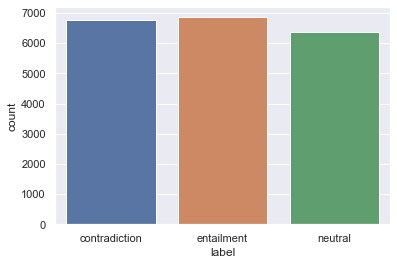

In [26]:
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="label", data=train)

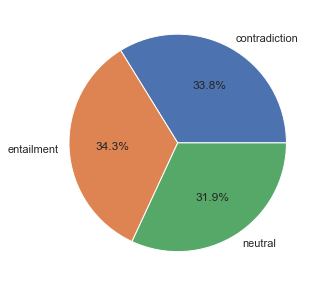

In [27]:
labels, frequencies = np.unique(train.label.values, return_counts=True)
plt.figure(figsize=(5,5))
plt.pie(frequencies, labels = labels, autopct= '%1.1f%%')
plt.show()

## 3. Modeling

최종 목표인 Stacking Ensemble을 적용하기 위해서 개별 모델 3가지를 구현했습니다.  
각각 사전학습된 ELECTRA, BERT, ALBERT 모델에 대해 fine-tune을 적용했습니다.  
이전 electra 개별 모델 구현 파일에서 토크나이징 후 조정할 패딩의 길이를 100으로 정했습니다.  
따라서, 각각의 모델들의 input_layer의 shape을 (100,)으로 지정했습니다.  

### 3.1 개별 모델 구현 함수

In [29]:
def model_KoELECTRA():
    with strategy.scope():
        encoder = TFElectraModel.from_pretrained("monologg/koelectra-base-v3-discriminator", from_pt=True)

        input_layer = Input(shape=(100,), dtype=tf.int32, name="input_layer")
        sequence_output = encoder(input_layer)[0]

        cls_token = sequence_output[:, 0, :]

        output_layer = Dense(3, activation='softmax')(cls_token)

        model = Model(inputs=input_layer, outputs=output_layer)
        model.compile(Adam(lr=1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

def model_BERT():
    with strategy.scope():
        encoder = TFBertModel.from_pretrained("kykim/bert-kor-base")

        input_layer = Input(shape=(100,), dtype=tf.int32, name="input_layer")
        sequence_output = encoder(input_layer)[0]

        cls_token = sequence_output[:, 0, :]

        output_layer = Dense(3, activation='softmax')(cls_token)

        model = Model(inputs=input_layer, outputs=output_layer)
        model.compile(Adam(lr=1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

def model_ALBERT():
    with strategy.scope():
        encoder = TFAlbertModel.from_pretrained("kykim/albert-kor-base")

        input_layer = Input(shape=(100,), dtype=tf.int32, name="input_layer")
        sequence_output = encoder(input_layer)[0]

        cls_token = sequence_output[:, 0, :]

        output_layer = Dense(3, activation='softmax')(cls_token)

        model = Model(inputs=input_layer, outputs=output_layer)
        model.compile(Adam(lr=1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

### 3.2 구현한 모델, 토크나이저 선언

In [30]:
model_bert = model_BERT()
model_albert = model_ALBERT()
model_electra = model_KoELECTRA()

All model checkpoint layers were used when initializing TFBertModel.

All the layers of TFBertModel were initialized from the model checkpoint at kykim/bert-kor-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(
All model checkpoint layers were used when initializing TFAlbertModel.

All the layers of TFAlbertModel were initialized from the model checkpoint at kykim/albert-kor-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFAlbertModel for predictions without further training.


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFElectraModel: ['discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.bias', 'electra.embeddings.position_ids', 'discriminator_predictions.dense.weight', 'discriminator_predictions.dense_prediction.weight']
- This IS expected if you are initializing TFElectraModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFElectraModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFElectraModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFElectraModel for predictions without further train

In [31]:
tokenizer_bert = BertTokenizerFast.from_pretrained("kykim/bert-kor-base")
tokenizer_albert = BertTokenizerFast.from_pretrained("kykim/albert-kor-base")
tokenizer_electra = ElectraTokenizer.from_pretrained("monologg/koelectra-base-v3-discriminator")

### 3.3 훈련 데이터 전처리

훈련데이터에 대해 각 문장에 대한 인코딩을 수행하고 패딩을 맞춰주는 전처리 작업을 진행합니다.  
토크나이징이 진행된 문장들에 대해 평균, 최대, 표준편차, 시각화를 통해 적절한 패딩 길이를 계산합니다.  
그 이후, 훈련데이터를 7:3 비율로 훈련데이터와 검증데이터를 나눕니다.  
검증데이터는 각 개별 모델로 예측을 진행하고, 클래스에 대한 예측 확률 값들과 예측 클래스 값들을 통해 앙상블 데이터로 사용하게 됩니다.  
따라서, 최종 제출할 대상이 되는 테스트 데이터에 대해서도 예측을 하고 예측 확률 값들과 클래스를 저장하는 같은 과정을 거치게 됩니다.  

#### 패딩 적절 길이 구하기

ELECTRA 모델과 BERT기반 두 가지의 모델로 패딩값을 정해야하기 때문에,  
각각의 토크나이저를 사용해 두 번 계산하여 패딩 길이를 구했습니다.  
첫 번째 ELECTRA 모델의 경우 평균 길이 40, 최대 길이 1680, 표준편차 17로 측정되었습니다.  
최종 예측해야할 테스트 파일의 경우 토큰의 최대 길이가 98이기 때문에 100의 길이가 적절하다고 판단했습니다.  
따라서, 100이상이 되는 훈련 데이터는 삭제했습니다.  
BERT 모델에 대해서도 똑같은 과정을 진행했습니다.  

In [32]:
train_data = train_all[['premise', 'hypothesis']].values.tolist()
test_data = test[['premise', 'hypothesis']].values.tolist()

#### ELECTRA

In [33]:
train_encoded_electra = tokenizer_electra.batch_encode_plus(train_data)
test_encoded_electra = tokenizer_electra.batch_encode_plus(test_data)

In [34]:
cal_length = train_encoded_electra['input_ids'] + test_encoded_electra['input_ids']

num_tokens = [len(tokens) for tokens in cal_length]
num_tokens = np.array(num_tokens)

# 평균값, 최댓값, 표준편차
print(f"토큰 길이 평균: {np.mean(num_tokens)}")
print(f"토큰 길이 최대: {np.max(num_tokens)}")
print(f"토큰 길이 표준편차: {np.std(num_tokens)}")

토큰 길이 평균: 40.551728276524244
토큰 길이 최대: 98
토큰 길이 표준편차: 13.612017136898697


In [35]:
test_num_tokens_electra = [len(tokens) for tokens in test_encoded_electra['input_ids']]
print(f"토큰 길이 최대: {np.max(test_num_tokens_electra)}")

토큰 길이 최대: 98


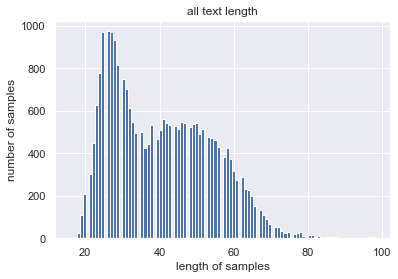

In [36]:
plt.title('all text length')
plt.hist(num_tokens, bins=100)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [37]:
select_length = 100

In [38]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [39]:
below_threshold_len(select_length, cal_length)

전체 샘플 중 길이가 100 이하인 샘플의 비율: 1.0


#### 길이가 100 이상인 데이터에 대해 삭제 진행  

In [40]:
temp = []
for i in range(len(train_encoded_electra['input_ids'])):
    if len(train_encoded_electra['input_ids'][i]) > select_length:
        temp.append(i)

temp.reverse()

for i in temp:
    del train_data[i]
    train_all.drop(train_all.index[i], inplace=True)
    
temp = []
for i in range(len(test_encoded_electra['input_ids'])):
    if len(test_encoded_electra['input_ids'][i]) > select_length:
        temp.append(i)

temp.reverse()

for i in temp:
    del test_data[i]
    test.drop(test.index[i], inplace=True)

#### BERT, ALBERT

In [41]:
train_encoded_bert = tokenizer_electra.batch_encode_plus(train_data)
test_encoded_bert = tokenizer_electra.batch_encode_plus(test_data)

In [42]:
cal_length = train_encoded_bert['input_ids'] + train_encoded_bert['input_ids']

num_tokens = [len(tokens) for tokens in cal_length]
num_tokens = np.array(num_tokens)

# 평균값, 최댓값, 표준편차
print(f"토큰 길이 평균: {np.mean(num_tokens)}")
print(f"토큰 길이 최대: {np.max(num_tokens)}")
print(f"토큰 길이 표준편차: {np.std(num_tokens)}")

토큰 길이 평균: 40.5627125425085
토큰 길이 최대: 98
토큰 길이 표준편차: 13.621406919583547


In [43]:
test_num_tokens_bert = [len(tokens) for tokens in test_encoded_bert['input_ids']]
print(f"토큰 길이 최대: {np.max(test_num_tokens_bert)}")

토큰 길이 최대: 98


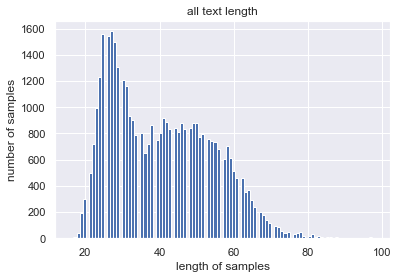

In [44]:
plt.title('all text length')
plt.hist(num_tokens, bins=100)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

#### 길이가 100 이상인 데이터에 대해 삭제 진행  

In [45]:
temp = []
for i in range(len(train_encoded_bert['input_ids'])):
    if len(train_encoded_bert['input_ids'][i]) > select_length:
        temp.append(i)

temp.reverse()

for i in temp:
    del train_data[i]
    train_all.drop(train_all.index[i], inplace=True)
    
temp = []
for i in range(len(test_encoded_bert['input_ids'])):
    if len(test_encoded_bert['input_ids'][i]) > select_length:
        temp.append(i)

temp.reverse()

for i in temp:
    del test_data[i]
    test.drop(test.index[i], inplace=True)

In [46]:
below_threshold_len(select_length, cal_length)

전체 샘플 중 길이가 100 이하인 샘플의 비율: 1.0


In [47]:
len(train_data)

19996

In [48]:
len(test_data)

5000

#### 3.3.1 ELECTRA 모델링

In [49]:
train_encoded_electra = tokenizer_electra.batch_encode_plus(train_data, padding='max_length', max_length=100)
test_encoded_electra = tokenizer_electra.batch_encode_plus(test_data, padding='max_length', max_length=100)

In [50]:
x_train, x_valid, y_train, y_valid = train_test_split(train_encoded_electra['input_ids'], train_all.label.values, test_size=0.3, shuffle=False)
x_test = test_encoded_electra['input_ids']

In [51]:
train_dataset = (tf.data.Dataset.from_tensor_slices((x_train, y_train)).repeat().shuffle(2048).batch(20 * strategy.num_replicas_in_sync).prefetch(tf.data.experimental.AUTOTUNE))
valid_dataset = (tf.data.Dataset.from_tensor_slices((x_valid, y_valid)).batch(20 * strategy.num_replicas_in_sync).cache().prefetch(tf.data.experimental.AUTOTUNE))
test_dataset = (tf.data.Dataset.from_tensor_slices(x_test).batch(20 * strategy.num_replicas_in_sync))

In [52]:
history_electra = model_electra.fit(train_dataset,steps_per_epoch=len(train) // 20 * strategy.num_replicas_in_sync,
                                     validation_data=valid_dataset,epochs= 1)

999/999 [==============================] - 223s 215ms/step - loss: 0.5277 - accuracy: 0.7821 - val_loss: 0.4057 - val_accuracy: 0.8581


앙상블 데이터를 만들 electra_pred(클래스에 대한 확률 예측 값들의 배열), electra_pred_class(각 행의 최종 예측 클래스 값들의 배열)  
최종 예측을 하기 위한 test_pred_electra (주어진 5000개의 테스트 데이터에 대한 확률 예측 값들의 배열),  
test_pred_electra_class (주어진 5000개의 테스트 데이터에 대한 최종 예측 클래스 값들의 배열)

In [53]:
electra_pred = model_electra.predict(x_valid, verbose=1)
electra_pred_class = np.argmax(electra_pred, axis=1)

188/188 [==============================] - 16s 81ms/step


In [54]:
test_pred_electra = model_electra.predict(test_dataset, verbose=1)
test_pred_electra_class = np.argmax(test_pred_electra, axis=1)

250/250 [==============================] - 14s 55ms/step


#### 3.3.2 BERT, ALBERT 모델링

In [55]:
train_encoded_bert = tokenizer_bert.batch_encode_plus(train_data, padding='max_length', max_length=100)
test_encoded_bert = tokenizer_bert.batch_encode_plus(test_data, padding='max_length', max_length=100)

In [56]:
x_train, x_valid, y_train, y_valid = train_test_split(train_encoded_bert['input_ids'], train_all.label.values, test_size=0.3, shuffle=False)
x_test = test_encoded_bert['input_ids']

In [57]:
train_dataset = (tf.data.Dataset.from_tensor_slices((x_train, y_train)).repeat().shuffle(2048).batch(20 * strategy.num_replicas_in_sync).prefetch(tf.data.experimental.AUTOTUNE))
valid_dataset = (tf.data.Dataset.from_tensor_slices((x_valid, y_valid)).batch(20 * strategy.num_replicas_in_sync).cache().prefetch(tf.data.experimental.AUTOTUNE))
test_dataset = (tf.data.Dataset.from_tensor_slices(x_test).batch(20 * strategy.num_replicas_in_sync))

In [58]:
history_bert = model_bert.fit(train_dataset,steps_per_epoch=len(train) // 20 * strategy.num_replicas_in_sync,
                              validation_data=valid_dataset, epochs= 1)

history_albert = model_albert.fit(train_dataset,steps_per_epoch=len(train) // 20 * strategy.num_replicas_in_sync,
                                  validation_data=valid_dataset, epochs= 1)

999/999 [==============================] - 223s 214ms/step - loss: 0.7415 - accuracy: 0.6641 - val_loss: 0.5494 - val_accuracy: 0.7798


앙상블 데이터를 만들 bert_pred(클래스에 대한 확률 예측 값들의 배열), bert_pred_class(각 행의 최종 예측 클래스 값들의 배열)  
최종 예측을 하기 위한 test_pred_bert (주어진 5000개의 테스트 데이터에 대한 확률 예측 값들의 배열),  
test_pred_bert_class (주어진 5000개의 테스트 데이터에 대한 최종 예측 클래스 값들의 배열)  
albert 모델도 변수명만 bert에서 albert로 동일합니다.  

In [59]:
bert_pred = model_bert.predict(x_valid, verbose=1)
albert_pred = model_albert.predict(x_valid)

188/188 [==============================] - 15s 78ms/step


In [60]:
bert_pred_class = np.argmax(bert_pred, axis=1)
albert_pred_class = np.argmax(albert_pred, axis=1)

In [61]:
test_pred_bert = model_bert.predict(test_dataset, verbose=1)
test_pred_albert = model_albert.predict(test_dataset, verbose=1)

test_pred_bert_class = np.argmax(test_pred_bert, axis=1)
test_pred_albert_class = np.argmax(test_pred_albert, axis=1)

250/250 [==============================] - 19s 76ms/step


## 4. Stacking & Boosting Ensemble learning

이전에 구했었던 검증 데이터에 대해 개별 모델로 예측한 메타데이터를 생성하여 스태킹 앙상블에 대한 훈련 데이터를 만들었습니다.  
또한, 최종 예측할 테스트 데이터에 대한 개별 모델 예측 메타데이터도 생성했습니다.  
만들어진 메타 데이터 학습을 하며 Stacking 앙상블을, 최종 판별 모델을 XGBoost를 사용하며 Boosting 앙상블을 적용했습니다.  
이렇게 만들어진 XGBoost 모델을 통해 테스트 메타 데이터에 똑같이 적용함으로써 최종 예측을 진행했습니다.  

### 4.1 메타 데이터 생성

위에서 구한 electra_pred, electra_pred_class, bert_pred, bert_pred_class, albert_pred, albert_pred_class 변수에 선언된 배열 값들을  
활용해 최종 판별 모델 XGBoost에 적용할 앙상블 데이터셋을 만들었습니다.  

In [62]:
meta_data = np.array([
    np.transpose(electra_pred)[0], np.transpose(electra_pred)[1], np.transpose(electra_pred)[2], electra_pred_class,
    np.transpose(bert_pred)[0], np.transpose(bert_pred)[1], np.transpose(bert_pred)[2], bert_pred_class,
    np.transpose(albert_pred)[0], np.transpose(albert_pred)[1], np.transpose(albert_pred)[2], albert_pred_class
])
print(meta_data.shape)

(12, 5999)


In [63]:
meta_data = np.transpose(meta_data)
print(meta_data.shape)

(5999, 12)


### 4.2 XGBoost Modeling

In [64]:
from xgboost import XGBClassifier

xgb_final = XGBClassifier(silent=False,
                          n_estimators = 10000,
                          booster='gbtree',
                          tree_method='gpu_hist',
                          preidctor= 'gpu_predictor',
                          learning_rate=0.02,
                          objective='multi:softmax',
                          max_depth = 8,
                          subsample = 0.8,
                          random_state=42)

In [65]:
final_model = xgb_final.fit(meta_data, y_valid)

[01:01:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "preidctor", "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:01:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [66]:
final = final_model.predict(meta_data)

In [67]:
print('최종 메타 모델의 예측 정확도: {0:.4f}'.format(accuracy_score(y_valid , final)))

최종 메타 모델의 예측 정확도: 1.0000


In [68]:
len(final)

5999

### 4.3 최종 예측 메타 데이터 생성 및 최종 판별 진행

In [70]:
test_meta_data = np.array([
    np.transpose(test_pred_electra)[0], np.transpose(test_pred_electra)[1], np.transpose(test_pred_electra)[2], test_pred_electra_class,
    np.transpose(test_pred_bert)[0], np.transpose(test_pred_bert)[1], np.transpose(test_pred_bert)[2], test_pred_bert_class,
    np.transpose(test_pred_albert)[0], np.transpose(test_pred_albert)[1], np.transpose(test_pred_albert)[2], test_pred_albert_class
])
print(test_meta_data.shape)

(12, 5000)


In [71]:
test_meta_data = np.transpose(test_meta_data)

(5999, 12)


In [72]:
print(test_meta_data.shape)

(5000, 12)


In [73]:
predictions = final_model.predict(test_meta_data)

In [74]:
predictions

array([0, 1, 2, ..., 2, 0, 0])

In [75]:
list1 = [i for i in range(5000)]

In [76]:
list2 = predictions

In [77]:
submission = pd.DataFrame({'index':list1,
                           'label':list2})

In [78]:
submission

,index,label
0,0,0
1,1,1
2,2,2
3,3,1
4,4,2
...,...,...
4995,4995,0
4996,4996,0
4997,4997,2
4998,4998,0


In [79]:
# contradiction => 0 entailment => 1 neutral => 2
submission['label'].replace(0, 'contradiction', inplace=True)
submission['label'].replace(1, 'entailment', inplace=True)
submission['label'].replace(2, 'neutral', inplace=True)

In [80]:
submission.to_csv("../submission/submission_stacking_v2.csv", index = False)

In [81]:
# model.save('competition_stacking_v1.h5')
# Load model code
# new_model = tf.keras.models.load_model('competition_stacking_v1.h5')
# test_loss, test_acc = new_model.evaluate(x,  y, verbose=2)